In [1]:
import sys
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
# plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 18,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )
# mpl.rcParams.update(
#     {'font.size': 18,
#      'font.family': 'sans-serif',
#      'font.sans-serif': ['Helvetica'],
#      'legend.fontsize': 14,
#      'axes.labelsize': 18,
#      'xtick.labelsize': 14,
#      'ytick.labelsize': 14
#     }
#     )
# mpl.rcParams

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-e1651/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/extensions', '/scratch/malvesga/.ipyth

In [2]:
from processing import lumi_periods_2017, lumi_periods_2018

lepton_type = 'muon'
# lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


### Event selection

In [3]:
def select_events( df_events, lepton_type, max_num_tracks = -1, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
    deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
#     msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
#                  ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    
    #msk_tau21_       = ( jet0_tau21_ <= 0.60 )
    msk_tau21_       = ( jet0_tau21_ <= 1 )
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
    
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )

#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )    
    msk_extra_tracks_ = None
    if max_num_tracks_ >= 0:
        msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    else:
        msk_extra_tracks_ = np.full( df_events.shape[0], True, dtype=bool )
    
    masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### MC (Bkg)

In [4]:
load_MC = True

labels_MC = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC = [ ]
    elif lepton_type == 'electron':
        labels_MC = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC = [ "Bkg-2018-muon-TTJets",
                      "Bkg-2018-muon-WJetsToLNu_0J", "Bkg-2018-muon-WJetsToLNu_1J", "Bkg-2018-muon-WJetsToLNu_2J",
                      "Bkg-2018-muon-DYJetsToLL_0J", "Bkg-2018-muon-DYJetsToLL_1J", "Bkg-2018-muon-DYJetsToLL_2J",
                      "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                      "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                      "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf",
                      "Bkg-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                      "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays",
                      "Bkg-2018-muon-WW",
                      "Bkg-2018-muon-WZ",
                      "Bkg-2018-muon-ZZ"
                    ]
    elif lepton_type == 'electron':
        labels_MC = [ "Bkg-2018-electron-TTJets", "Bkg-2018-electron-WJetsToLNu_0J", "Bkg-2018-electron-WJetsToLNu_1J", "Bkg-2018-electron-WJetsToLNu_2J" ]
    
df_counts_MC = {}
df_events_MC = {}
if load_MC:
    base_path_ = "output_events"
    for label_ in labels_MC:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_MC[ label_ ] = store_[ "counts" ]
            print ( df_counts_MC[ label_ ] )
            df_events_MC[ label_ ] = store_[ "events" ]

Bkg-2018-muon-TTJets
['/counts', '/events']
All           3842337
Jet           3842337
Muon          2087369
check_none    2087369
dtype: int64
Bkg-2018-muon-WJetsToLNu_0J
['/counts', '/events']
All           4
Jet           4
Muon          1
check_none    1
dtype: int64
Bkg-2018-muon-WJetsToLNu_1J
['/counts', '/events']
All           108506
Jet           108506
Muon           58261
check_none     58261
dtype: int64
Bkg-2018-muon-WJetsToLNu_2J
['/counts', '/events']
All           13551
Jet           13551
Muon           7206
check_none     7206
dtype: int64
Bkg-2018-muon-DYJetsToLL_0J
['/counts', '/events']
All           275
Jet           275
Muon           98
check_none     98
dtype: int64
Bkg-2018-muon-DYJetsToLL_1J
['/counts', '/events']
All           121850
Jet           121850
Muon           63333
check_none     63333
dtype: int64
Bkg-2018-muon-DYJetsToLL_2J
['/counts', '/events']
All           355205
Jet           355205
Muon          188036
check_none    188036
dtype: int64
Bkg

In [5]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = ''
    elif lepton_type == 'electron':
        label_ref_ = ''
elif data_sample == '2018':
    if lepton_type == 'muon':
#         label_ref_ = 'Bkg-2018-muon-TTJets'
        label_ref_ = 'Bkg-2018-muon-WJetsToLNu_1J'
    elif lepton_type == 'electron':
#         label_ref_ = 'Bkg-2018-electron-TTJets'
        label_ref_ = 'Bkg-2018-electron-WJetsToLNu_1J'

print ( df_events_MC[ label_ref_ ].columns.values )
df_events_MC[ label_ref_ ]

['run' 'lumiblock' 'event' 'crossingAngle' 'betaStar' 'instLumi' 'jet0_pt'
 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'jet0_px' 'jet0_py' 'jet0_pz'
 'calo_met' 'met' 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8'
 'num_bjets_ak4' 'num_jets_ak4' 'pfcand_nextracks'
 'pfcand_nextracks_noDRl' 'recoMWhad' 'recoMWlep' 'recoMWW'
 'recoRapidityWW' 'dphiWW' 'WLeptonicPt' 'WLeptonicEta' 'WLeptonicPhi'
 'muon0_pt' 'muon0_eta' 'muon0_phi' 'muon0_energy' 'muon0_charge'
 'muon0_iso' 'muon0_dxy' 'muon0_dz' 'muon0_trackerLayersWithMeasurement'
 'run_mc' 'pileupWeight' 'mc_pu_trueinteractions' 'mcWeight'
 'prefiring_weight' 'prefiring_weight_up' 'prefiring_weight_down'
 'prefiring_weight_ECAL' 'prefiring_weight_ECAL_up'
 'prefiring_weight_ECAL_down' 'prefiring_weight_Muon'
 'prefiring_weight_Muon_up' 'prefiring_weight_Muon_down' 'jet0_jer_res'
 'jet0_jer_sf' 'jet0_jer_sfup' 'jet0_jer_sfdown' 'jet0_cjer'
 'jet0_cjer_up' 'jet0_cjer_down

,run,lumiblock,event,crossingAngle,betaStar,instLumi,jet0_pt,jet0_eta,jet0_phi,jet0_energy,...,xiCMS_45_nom,xiCMS_56_nom,xiCMS_45_jes_up,xiCMS_56_jes_up,xiCMS_45_jes_dw,xiCMS_56_jes_dw,xiCMS_45_jer_up,xiCMS_56_jer_up,xiCMS_45_jer_dw,xiCMS_56_jer_dw
0,1,24,122247,140.0,0.0,0.0,251.796326,1.723576,0.646610,731.689819,...,0.168523,0.012093,0.170755,0.012164,0.166291,0.012022,0.168353,0.012087,0.168692,0.012098
1,1,168121,866495552,140.0,0.0,0.0,338.870972,0.324337,2.662648,362.695251,...,0.055978,0.055850,0.056185,0.055959,0.055770,0.055742,0.055941,0.055831,0.056014,0.055869
2,1,168121,866495616,140.0,0.0,0.0,438.010468,-0.016506,-0.267117,443.935150,...,0.115037,0.049119,0.115207,0.049294,0.114867,0.048943,0.115037,0.049118,0.115038,0.049119
3,1,86179,444162848,140.0,0.0,0.0,302.518951,1.095818,1.680920,507.019806,...,0.086392,0.035989,0.086945,0.036051,0.085839,0.035927,0.086612,0.036014,0.086172,0.035965
4,1,86273,444648576,140.0,0.0,0.0,315.788391,1.650977,1.350798,855.124573,...,0.220275,0.010695,0.222623,0.010781,0.217928,0.010608,0.220376,0.010698,0.220176,0.010691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58256,1,134249,691916416,140.0,0.0,0.0,246.672913,1.522978,2.154280,594.526794,...,0.192970,0.007852,0.194787,0.007939,0.191153,0.007766,0.193051,0.007856,0.192890,0.007849
58257,1,134249,691916736,140.0,0.0,0.0,292.245728,-1.890074,0.434087,993.816284,...,0.026928,0.169584,0.026994,0.172459,0.026863,0.166709,0.026961,0.171011,0.026896,0.168157
58258,1,134250,691923776,140.0,0.0,0.0,201.832901,-1.019135,-1.172299,317.947632,...,0.016796,0.064495,0.016853,0.064932,0.016740,0.064058,0.016786,0.064414,0.016807,0.064577
58259,1,196399,1012236864,140.0,0.0,0.0,252.045731,0.110033,-0.967943,262.801453,...,0.034038,0.046699,0.034181,0.046814,0.033895,0.046585,0.034035,0.046697,0.034041,0.046702


In [6]:
labels_samples = {
    "Bkg-2018-muon-TTJets": r"$t \bar{t} + \rm{jets}$",
    "Bkg-2018-electron-TTJets": r"$t \bar{t} + \rm{jets}$",
    "Bkg-2018-muon-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
    "Bkg-2018-electron-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
    "Bkg-2018-muon-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
    "Bkg-2018-electron-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
    "Bkg-2018-muon-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
    "Bkg-2018-electron-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
    "Bkg-2018-muon-WJetsToLNu": r"$W + \rm{jets}$",
    "Bkg-2018-electron-WJetsToLNu": r"$W + \rm{jets}$",
    "Bkg-2018-muon-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
    "Bkg-2018-electron-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
    "Bkg-2018-muon-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
    "Bkg-2018-electron-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
    "Bkg-2018-muon-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
    "Bkg-2018-electron-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
    "Bkg-2018-muon-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
    "Bkg-2018-electron-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
    "Bkg-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-muon-QCD": r"QCD",
    "Bkg-2018-electron-QCD": r"QCD",
    "Bkg-2018-muon-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
    "Bkg-2018-electron-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
    "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
    "Bkg-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
    "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
    "Bkg-2018-electron-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
    "Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
    "Bkg-2018-electron-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
    "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
    "Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
    "Bkg-2018-muon-ST": r"single top",
    "Bkg-2018-electron-ST": r"single top",
    "Bkg-2018-muon-WW": r"$WW$",
    "Bkg-2018-electron-WW": r"$WW$",
    "Bkg-2018-muon-WZ": r"$WZ$",
    "Bkg-2018-electron-WZ": r"$WZ$",
    "Bkg-2018-muon-ZZ": r"$ZZ$",
    "Bkg-2018-electron-ZZ": r"$ZZ$",
    "Bkg-2018-muon-VV": r"$VV$",
    "Bkg-2018-electron-VV": r"$VV$"
}

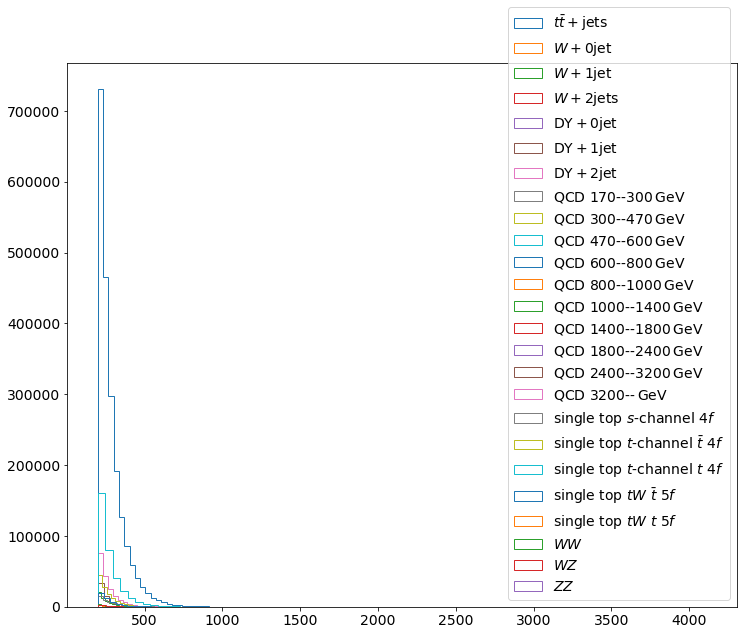

In [7]:
var__ = "jet0_pt_nom"
if load_MC:
    fig = plt.figure( figsize=(12,10) )
    for label__ in labels_MC: 
        plt.hist( df_events_MC[ label__ ][ var__ ], histtype='step', density=False, bins=50, label=labels_samples[ label__ ] )
    plt.legend( loc='best', fontsize=14 )

### Select events

In [8]:
df_selected_events_MC = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw", "_jer_up", "_jer_dw" ] }
for label__ in labels_MC:
    print ( label__ )
    df_events__ = df_events_MC[ label__ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__, lepton_type )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_selected_events_MC[ label__ ] = {}
    df_selected_events_MC[ label__ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__  = select_events( df_events__, lepton_type, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_selected_events_MC[ label__ ][ variation__ ] = df_selected_events__

Bkg-2018-muon-TTJets
2087369
164705
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2087369, 'Muon': 2084684, 'Jet': 1615882, 'Jet_Muon': 1576382, 'MET': 1346953, 'Jet_MET': 1160191, 'PrunedMass': 565210, 'Tau21': 565210, 'BJet_Veto': 321951, 'Xi_CMS': 299256, 'WLeptonic': 180528, 'Jet_WLeptonic': 173154, 'MWW': 164705, 'ExtraTracks': 164705}
jet
{'label_jet': '_jes_up'}
165628
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2087369, 'Muon': 2084684, 'Jet': 1668634, 'Jet_Muon': 1626729, 'MET': 1387777, 'Jet_MET': 1192705, 'PrunedMass': 578403, 'Tau21': 578403, 'BJet_Veto': 329472, 'Xi_CMS': 305550, 'WLeptonic': 182593, 'Jet_WLeptonic': 174968, 'MWW': 165628, 'ExtraTracks': 165628}
{'label_jet': '_jes_dw'}
163728
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'Pr

695
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 63333, 'Muon': 63305, 'Jet': 41774, 'Jet_Muon': 41739, 'MET': 16768, 'Jet_MET': 14205, 'PrunedMass': 1301, 'Tau21': 1301, 'BJet_Veto': 1300, 'Xi_CMS': 1041, 'WLeptonic': 784, 'Jet_WLeptonic': 784, 'MWW': 695, 'ExtraTracks': 695}
jet
{'label_jet': '_jes_up'}
716
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 63333, 'Muon': 63305, 'Jet': 44095, 'Jet_Muon': 44052, 'MET': 17611, 'Jet_MET': 14933, 'PrunedMass': 1423, 'Tau21': 1423, 'BJet_Veto': 1420, 'Xi_CMS': 1123, 'WLeptonic': 826, 'Jet_WLeptonic': 826, 'MWW': 716, 'ExtraTracks': 716}
{'label_jet': '_jes_dw'}
655
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All':

81
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1684, 'Muon': 1682, 'Jet': 1678, 'Jet_Muon': 1676, 'MET': 1446, 'Jet_MET': 1273, 'PrunedMass': 178, 'Tau21': 178, 'BJet_Veto': 160, 'Xi_CMS': 87, 'WLeptonic': 81, 'Jet_WLeptonic': 81, 'MWW': 81, 'ExtraTracks': 81}
jet
{'label_jet': '_jes_up'}
79
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1684, 'Muon': 1682, 'Jet': 1678, 'Jet_Muon': 1676, 'MET': 1446, 'Jet_MET': 1273, 'PrunedMass': 176, 'Tau21': 176, 'BJet_Veto': 159, 'Xi_CMS': 85, 'WLeptonic': 79, 'Jet_WLeptonic': 79, 'MWW': 79, 'ExtraTracks': 79}
{'label_jet': '_jes_dw'}
84
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1684, 'Muon': 1682, 'Jet': 1678,

0
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 72, 'Muon': 72, 'Jet': 72, 'Jet_Muon': 72, 'MET': 71, 'Jet_MET': 51, 'PrunedMass': 11, 'Tau21': 11, 'BJet_Veto': 10, 'Xi_CMS': 0, 'WLeptonic': 0, 'Jet_WLeptonic': 0, 'MWW': 0, 'ExtraTracks': 0}
Bkg-2018-muon-QCD_Pt_3200toInf
20
0
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 20, 'Muon': 20, 'Jet': 20, 'Jet_Muon': 20, 'MET': 20, 'Jet_MET': 14, 'PrunedMass': 7, 'Tau21': 7, 'BJet_Veto': 7, 'Xi_CMS': 0, 'WLeptonic': 0, 'Jet_WLeptonic': 0, 'MWW': 0, 'ExtraTracks': 0}
jet
{'label_jet': '_jes_up'}
0
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 20, 'Muon': 20, 'Jet': 20, 'Jet_Muon': 20, 'MET': 20, 'Jet_MET': 14, 

6499
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 50829, 'Muon': 50788, 'Jet': 39523, 'Jet_Muon': 39036, 'MET': 33836, 'Jet_MET': 30557, 'PrunedMass': 15443, 'Tau21': 15443, 'BJet_Veto': 10529, 'Xi_CMS': 9798, 'WLeptonic': 7015, 'Jet_WLeptonic': 6825, 'MWW': 6499, 'ExtraTracks': 6499}
jet
{'label_jet': '_jes_up'}
6555
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 50829, 'Muon': 50788, 'Jet': 40756, 'Jet_Muon': 40228, 'MET': 34801, 'Jet_MET': 31376, 'PrunedMass': 15776, 'Tau21': 15776, 'BJet_Veto': 10770, 'Xi_CMS': 9994, 'WLeptonic': 7118, 'Jet_WLeptonic': 6925, 'MWW': 6555, 'ExtraTracks': 6555}
{'label_jet': '_jes_dw'}
6429
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'Extr

In [9]:
df_selected_events_MC

{'Bkg-2018-muon-TTJets': {'_nom':        run  lumiblock      event  crossingAngle  betaStar  instLumi  \
  21       1        562    1459393          140.0       0.0       0.0   
  38       1        570    1480147          140.0       0.0       0.0   
  58       1     289588  752057728          140.0       0.0       0.0   
  75       1     288032  748017920          140.0       0.0       0.0   
  105      1     326032  846705024          140.0       0.0       0.0   
  ...    ...        ...        ...            ...       ...       ...   
  87274    1      71130  184722512          140.0       0.0       0.0   
  87288    1      70489  183058240          140.0       0.0       0.0   
  87294    1      70489  183059904          140.0       0.0       0.0   
  87323    1     164225  426491392          140.0       0.0       0.0   
  87344    1     315065  818223552          140.0       0.0       0.0   
  
            jet0_pt  jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_45_nom  \
  21     337.6

In [10]:
import json
samples_info = None
if data_sample == '2017':
    pass
elif data_sample == '2018':
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [100000.0, 0.045393, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [100000.0, 0.058313, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [100000.0, 0.148122, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [99000.0, 0.16477, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [100000.0, 0.049199, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_8e-6_semi_pt0': [100000.0, 0.061404, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 0.0409705, 1.0, 6],
 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8': [200205760.0, 831.76, 1.0, 800],
 'WW_TuneCP5_13TeV-pythia8': [6013000.0, 75.95, 1.0, 800],
 'WZ_TuneCP5_13TeV-pythia8': [6017000.0, 27.59, 1.0, 800],
 'ZZ_TuneCP5_13TeV-pythia8': [3000.0, 12.17, 1.0, 800],
 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8': [7654000.0,
  3.549,
  1.0,
  800],
 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8': [178756000.0,
  115.3,
  1.0,
  800],
 'ST

In [11]:
sample_names = {}
if data_sample == '2017':
    pass
elif data_sample == '2018':
    sample_names[ "Bkg-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
    sample_names[ "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
    sample_names[ "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
    sample_names[ "Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
    sample_names[ "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
    sample_names[ "Bkg-2018-muon-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'

In [12]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )
    
norm_factors = {}
for label__ in labels_MC:
    print ( label__ )
    print ( samples_info[ sample_names[ label__ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label__ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
#     if norm_to_1fb:
#         sample_cross_section_ = 1.e-03
    print ( sample_cross_section_ )
    norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label__ ] )
    norm_factors_product_ = np.product( norm_factors[ label__ ] )
    print ( norm_factors_product_ )
    if df_selected_events_MC[ label__ ][ "_nom" ].shape[0] > 0:
        df_selected_events_MC[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_selected_events_MC[ label__ ]:
        print ( variation__ )
        if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
            df_selected_events_MC[ label__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

59.76559325367668
Bkg-2018-muon-TTJets
[200205760.0, 831.76, 1.0, 800]
831.76
[2.98520848e-07 8.31760000e+05 1.00000000e+00]
0.2482977005490657
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-WJetsToLNu_0J
[43564756.0, 53330, 1.0, 800]
53330.0
[1.37187944e-06 5.33300000e+07 1.00000000e+00]
73.16233076614907
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-WJetsToLNu_1J
[109938200.0, 8875, 1.0, 800]
8875.0
[5.43628996e-07 8.87500000e+06 1.00000000e+00]
4.824707336725365
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-WJetsToLNu_2J
[1755467.0, 3338, 1.0, 800]
3338.0
[3.40454097e-05 3.33800000e+06 1.00000000e+00]
113.64357762394437
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-DYJetsToLL_0J
[49476008.0, 5129, 1.0, 800]
5129.0
[1.20797121e-06 5.12900000e+06 1.00000000e+00]
6.195684336499171
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-DYJetsToLL_1J
[72888824.0, 951.5, 1.0, 800]
951.5
[8.19955515e-07 9.51500000e+05 1.00000000e+00]
0.7801876729534469
_nom
_jes_up
_jes_dw
_

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
var_name__ = ""
if lepton_type == 'muon':
    var_name__ = "sf_muon_id"
elif lepton_type == 'electron':
    var_name__ = "sf_electron_id"
var_name_up__ = var_name__ + "_up"
var_name_dw__ = var_name__ + "_dw"

df_selected_events_MC[ "Bkg-2018-muon-TTJets" ][ "_nom" ][ [ var_name__, var_name_up__, var_name_dw__ ] ]

,sf_muon_id,sf_muon_id_up,sf_muon_id_dw
21,0.995787,0.996356,0.995218
38,0.996643,0.997023,0.996263
58,0.996643,0.997023,0.996263
75,0.996643,0.997023,0.996263
105,0.996643,0.997023,0.996263
...,...,...,...
87274,0.996643,0.997023,0.996263
87288,0.996095,0.996925,0.995265
87294,0.996643,0.997023,0.996263
87323,0.996643,0.997023,0.996263


In [14]:
df_selected_events_MC[ "Bkg-2018-muon-TTJets" ][ "_nom" ][ [ "pileupWeight" ] ]

,pileupWeight
21,0.986887
38,0.990842
58,1.081837
75,0.998228
105,0.918710
...,...
87274,1.006624
87288,1.109821
87294,0.986887
87323,1.005129


In [15]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_WJetsToLNu = "Bkg-2018-muon-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-2018-muon-WJetsToLNu_0J", "Bkg-2018-muon-WJetsToLNu_1J", "Bkg-2018-muon-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-2018-muon-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-2018-muon-DYJetsToLL_0J", "Bkg-2018-muon-DYJetsToLL_1J", "Bkg-2018-muon-DYJetsToLL_2J" ]
        label_QCD = "Bkg-2018-muon-QCD"
        samples_QCD = [ "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                        "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-2018-muon-ST"
        samples_ST = [ "Bkg-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-2018-muon-VV"
        samples_VV = [ "Bkg-2018-muon-WW",
                       "Bkg-2018-muon-WZ",
                       "Bkg-2018-muon-ZZ" ]
    elif lepton_type == 'electron':
        label_WJetsToLNu = "Bkg-2018-electron-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-2018-electron-WJetsToLNu_0J", "Bkg-2018-electron-WJetsToLNu_1J", "Bkg-2018-electron-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-2018-electron-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-2018-electron-DYJetsToLL_0J", "Bkg-2018-electron-DYJetsToLL_1J", "Bkg-2018-electron-DYJetsToLL_2J" ]
        label_QCD = "Bkg-2018-electron-QCD"
        samples_QCD = [ "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                        "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-2018-electron-ST"
        samples_ST = [ "Bkg-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-2018-electron-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-2018-electron-VV"
        samples_VV = [ "Bkg-2018-electron-WW",
                       "Bkg-2018-electron-WZ",
                       "Bkg-2018-electron-ZZ" ]

df_selected_events_MC[ label_WJetsToLNu ] = {}
df_selected_events_MC[ label_DYJetsToLL ] = {}
df_selected_events_MC[ label_QCD ] = {}
df_selected_events_MC[ label_ST ] = {}
df_selected_events_MC[ label_VV ] = {}
for variation__ in df_selected_events_MC[ samples_WJetsToLNu[ 0 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )
    
labels_MC.append( label_WJetsToLNu )
labels_MC.append( label_DYJetsToLL )
labels_MC.append( label_QCD )
labels_MC.append( label_ST )
labels_MC.append( label_VV )
# print ( df_selected_events_MC[ label_WJetsToLNu ] )

_nom
_jes_up
_jes_dw
_jer_up
_jer_dw


In [16]:
df_selected_events_MC[ label_QCD ]

{'_nom':      run  lumiblock     event  crossingAngle  betaStar  instLumi      jet0_pt  \
 9      1        549    548657          140.0       0.0       0.0   266.973663   
 20     1      23229  23228708          140.0       0.0       0.0   250.477478   
 85     1      10364  10363608          140.0       0.0       0.0   263.846222   
 150    1      26787  26786616          140.0       0.0       0.0   290.871002   
 151    1       2946   2945753          140.0       0.0       0.0   268.572784   
 ..   ...        ...       ...            ...       ...       ...          ...   
 436    1      14981  14980504          140.0       0.0       0.0  1011.576782   
 21     1       6044   6043942          140.0       0.0       0.0  1136.959961   
 79     1      13272  13271426          140.0       0.0       0.0  1089.321655   
 230    1      16057  16056964          140.0       0.0       0.0  1053.879761   
 132    1       8737   8736495          140.0       0.0       0.0   808.171204   
 
      

In [17]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )

variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )

var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"

var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"

print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_MC = {}
for label__ in labels_MC:
    print ( label__ )
    
    weights_events_MC[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_MC[ label__ ][ var_weights__ ] = {}
        for variation__ in df_selected_events_MC[ label__ ]:
            df_selected_events__ = df_selected_events_MC[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_MC )

['nom', 'sf_muon_id_up', 'sf_muon_id_dw', 'sf_muon_trigger_up', 'sf_muon_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_muon_id', 'sf_prefiring_up': 'sf_muon_id', 'sf_prefiring_dw': 'sf_muon_id', 'sf_muon_trigger_up': 'sf_muon_id', 'sf_muon_trigger_dw': 'sf_muon_id', 'sf_muon_id_up': 'sf_muon_id_up', 'sf_muon_id_dw': 'sf_muon_id_dw'}
{'nom': 'sf_muon_trigger', 'sf_prefiring_up': 'sf_muon_trigger', 'sf_prefiring_dw': 'sf_muon_trigger', 'sf_muon_id_up': 'sf_muon_trigger', 'sf_muon_id_dw': 'sf_muon_trigger', 'sf_muon_trigger_up': 'sf_muon_trigger_up', 'sf_muon_trigger_dw': 'sf_muon_trigger_dw'}
{'nom': 'prefiring_weight', 'sf_muon_id_up': 'prefiring_weight', 'sf_muon_id_dw': 'prefiring_weight', 'sf_muon_trigger_up': 'prefiring_weight', 'sf_muon_trigger_dw': 'prefiring_weight', 'sf_prefiring_up': 'prefiring_weight_up', 'sf_prefiring_dw': 'prefiring_weight_down'}
Bkg-2018-muon-TTJets
Bkg-2018-muon-WJetsToLNu_0J
Bkg-2018-muon-WJetsToLNu_1J
Bkg-2018-muon-WJetsToLNu_2J
Bkg-2018

### Plot MC

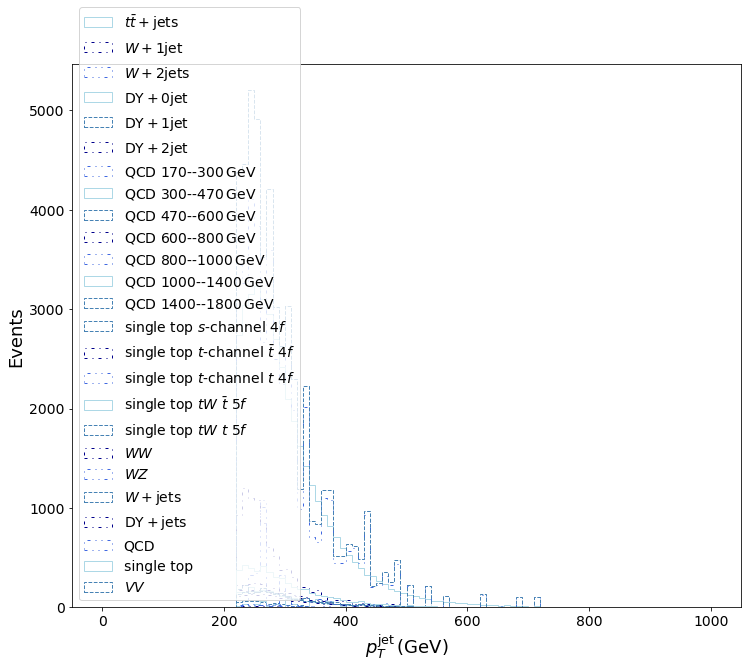

In [18]:
fig = plt.figure( figsize=(12,10) )

variation__ = "_nom"
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]

linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

range_ = (0., 1000.) 
bins_ = 100

for idx__, label__ in enumerate( labels_MC ):
    if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
        plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ "jet0_pt" + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
                  histtype='step', color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )

plt.xlabel( r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $", fontsize=18 )
plt.ylabel( "Events", fontsize=18 )
plt.legend( loc='best', fontsize=14 )

### Data

In [19]:
labels_data = []
fileNames_data = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_data = [ ]
        fileNames_data = {
            
        }
    elif lepton_type == 'electron':
        labels_data = [ ]
        fileNames_data = {
            
        }
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_data = [
            "data-2018-muon-2018A",
            "data-2018-muon-2018B",
            "data-2018-muon-2018C",
            "data-2018-muon-2018D"
        ]
        fileNames_data = {
            "data-2018-muon-2018A": "data-store-data-2018-muon-events-2018A.h5",
            "data-2018-muon-2018B": "data-store-data-2018-muon-events-2018B.h5",
            "data-2018-muon-2018C": "data-store-data-2018-muon-events-2018C.h5",
            "data-2018-muon-2018D": "data-store-data-2018-muon-events-2018D.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [
            "data-2018-electron-2018A",
            "data-2018-electron-2018B",
            "data-2018-electron-2018C",
            "data-2018-electron-2018D"
        ]
        fileNames_data = {
            "data-2018-electron-2018A": "data-store-data-2018-electron-events-2018A.h5",
            "data-2018-electron-2018B": "data-store-data-2018-electron-events-2018B.h5",
            "data-2018-electron-2018C": "data-store-data-2018-electron-events-2018C.h5",
            "data-2018-electron-2018D": "data-store-data-2018-electron-events-2018D.h5"
        }

base_path_ = 'output_events'
for label_ in fileNames_data:
    fileNames_data[ label_ ] = "{}/{}".format( base_path_, fileNames_data[ label_ ] )
print ( fileNames_data )

df_counts_data = None
df_events_data = None

df_counts_data_list_ = []
df_events_data_list_ = []
for label__ in labels_data:
    print ( label__ )
    file_path_ = fileNames_data[ label__ ]
    print ( file_path_ )
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        
        df_counts_data__ = store_[ "counts" ]
        df_events_data__ = store_[ "events" ]
        df_counts_data_list_.append( df_counts_data__ )
        df_events_data_list_.append( df_events_data__ )

df_counts_data = df_counts_data_list_[0]
for idx_ in range( 1, len( df_counts_data_list_ ) ):
    df_counts_data = df_counts_data.add( df_counts_data_list_[ idx_ ] )

df_events_data = pd.concat( df_events_data_list_ )

{'data-2018-muon-2018A': 'output_events/data-store-data-2018-muon-events-2018A.h5', 'data-2018-muon-2018B': 'output_events/data-store-data-2018-muon-events-2018B.h5', 'data-2018-muon-2018C': 'output_events/data-store-data-2018-muon-events-2018C.h5', 'data-2018-muon-2018D': 'output_events/data-store-data-2018-muon-events-2018D.h5'}
data-2018-muon-2018A
output_events/data-store-data-2018-muon-events-2018A.h5


OSError: ``output_events/data-store-data-2018-muon-events-2018A.h5`` does not exist

In [ ]:
df_counts_data

In [ ]:
df_events_data

### Select events

In [ ]:
df_events_data__, selection_keys_, selections_ = select_events( df_events_data, lepton_type )
df_events_data = df_events_data__
print ( df_events_data.shape[0] )
print ( selection_keys_ )
print ( selections_ )

### Plot Data/MC

In [ ]:
labels_MC_plot = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC_plot = [ ]
    elif lepton_type == 'electron':
        labels_MC_plot = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC_plot = [ "Bkg-2018-muon-TTJets", "Bkg-2018-muon-WJetsToLNu", "Bkg-2018-muon-DYJetsToLL", "Bkg-2018-muon-QCD", "Bkg-2018-muon-ST", "Bkg-2018-muon-VV" ]
#         labels_MC_plot = [ "Bkg-2018-muon-TTJets", "Bkg-2018-muon-WJetsToLNu", "Bkg-2018-muon-DYJetsToLL", "Bkg-2018-muon-VV" ]
    elif lepton_type == 'electron':
        labels_MC_plot = [ "Bkg-2018-electron-TTJets", "Bkg-2018-electron-WJetsToLNu", "Bkg-2018-electron-DYJetsToLL", "Bkg-2018-electron-QCD", "Bkg-2018-electron-ST", "Bkg-2018-electron-VV" ]

In [ ]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_str__[ "_jes_up" ] = "_jes_up"
var_str__[ "_jes_dw" ] = "_jes_dw"
var_str__[ "_jer_up" ] = "_jer_up"
var_str__[ "_jer_dw" ] = "_jer_dw"

def plot_MC_data( variable, variation, variation_weights, bins, range, xlabel ):

    variable__ = variable
    variation__ = variation
    variation_weights__ = variation_weights
    bins__ = bins
    range__ = range
    xlabel__ = xlabel
    
    fig = plt.figure( figsize=(12,10) )

    colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]

    linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

    arr_data_MC_ = []
    weights_data_MC_ = []
    colors_MC_ = []
    labels_MC_ = []
    for idx__, label__ in enumerate( labels_MC_plot ):
        if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
            arr_data_MC_.append( df_selected_events_MC[ label__ ][ variation__ ][ variable__ + var_str__[ variation__ ] ] )
            weights_data_MC_.append( weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] )
            colors_MC_.append( colors_[ idx__ % len( colors_ ) ] )
            labels_MC_.append( labels_samples[ label__ ] )

    # plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ variable__ + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
    #           stacked=True, color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )
    plt.hist( arr_data_MC_, weights=weights_data_MC_,
              stacked=True, color=colors_MC_, label=labels_MC_, range=range_, bins=bins_ )

    counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    plt.xlabel( xlabel__, fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    

In [ ]:
variation__ = "_nom"
variation_weights__ = "nom"
variable__ = "jet0_pt"
range_ = (200., 1000.) 
bins_ = 30
xlabel_ = r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $"
plot_MC_data( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

In [ ]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_str__[ "_jes_up" ] = "_jes_up"
var_str__[ "_jes_dw" ] = "_jes_dw"
var_str__[ "_jer_up" ] = "_jer_up"
var_str__[ "_jer_dw" ] = "_jer_dw"

def get_MC_histogram_label( label, variable, variation, variation_weights, bins, range ):
       
    df_events__ = df_selected_events_MC[ label ][ variation ][ variable + var_str__[ variation ] ]
    weights_events__ = weights_events_MC[ label ][ variation_weights ][ variation ]
    weights2_events__ = ( weights_events__ ** 2 )
        
    sum_weights_bins__, bin_edges__ = np.histogram( df_events__, weights=weights_events__, bins=bins, range=range )
    sum_weights2_bins__, __ = np.histogram( df_events__, weights=weights2_events__, bins=bins, range=range )
        
    return ( sum_weights_bins__, sum_weights2_bins__, bin_edges__ )
        
def get_MC_histogram_all( variable, variation, variation_weights, bins, range ):
    
    sum_weights_bins_all_ = None
    sum_weights2_bins_all_ = None
    bin_edges_ = None
    for label__ in labels_MC_plot:
        sum_weights_bins__, sum_weights2_bins__, bin_edges__ = get_MC_histogram_label( label__, variable, variation, variation_weights, bins, range )
        if sum_weights_bins_all_ is None:
            sum_weights_bins_all_ = sum_weights_bins__
            sum_weights2_bins_all_ = sum_weights2_bins__
            bin_edges_ = bin_edges__
        else:
            sum_weights_bins_all_ = ( sum_weights_bins_all_ + sum_weights_bins__ )
            sum_weights2_bins_all_ = ( sum_weights2_bins_all_ + sum_weights2_bins__ )
        
    return ( sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ )

def get_uncertainties_variations( variable, variations, scale_variation, bins, range ):
    
    max__ = None
    min__ = None
    
    for idx_, variation__ in enumerate( variations ):
        __variation__ = variation__ if not scale_variation else "_nom"
        __var_str__ = var_str__[ __variation__ ] if not scale_variation else "_nom"
        __variation_weights__ = variation__ if scale_variation else "nom"
        if variation__ != "_nom" and variation__ != "nom":
            print ( __variation__ )
            print ( __var_str__ )
            print ( __variation_weights__ )
                
            sum_weights__, sum_weights2__, bin_edges__ = get_MC_histogram_all( variable, __variation__, __variation_weights__, bins, range )
                
            if max__ is None: max__ = sum_weights__.copy()
            if min__ is None: min__ = sum_weights__.copy()
            msk__ = ( sum_weights__ > max__ )
            max__[ msk__ ] = sum_weights__[ msk__ ]
            msk__ = ( sum_weights__ < min__ )
            min__[ msk__ ] = sum_weights__[ msk__ ]
                
    return ( max__, min__ )    

def get_total_uncertainty( variable, bins, range ):

    lepton_type__ = lepton_type
    variable__ = variable
    bins__ = bins
    range__ = range
    
    max_variations__ = {}
    min_variations__ = {}
    
    variations__ = [ "_nom", "_jes_up", "_jes_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations__, scale_variation=False, bins=bins__, range=range__ )
    max_variations__[ "jes" ] = weights_max__
    min_variations__[ "jes" ] = weights_min__
    
    variations__ = [ "_nom", "_jer_up", "_jer_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations__, scale_variation=False, bins=bins__, range=range__ )
    max_variations__[ "jer" ] = weights_max__
    min_variations__[ "jer" ] = weights_min__
    
    variations_weights__ = []
    if lepton_type__ == 'muon':
        variations_weights__ = [ "nom", "sf_muon_id_up", "sf_muon_id_dw" ]
    elif lepton_type__ == 'electron':
        variations_weights__ = [ "nom", "sf_electron_id_up", "sf_electron_id_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations_weights__, scale_variation=True, bins=bins__, range=range__ )
    
    variation_name_lepton_id__ = ""
    if lepton_type__ == 'muon': variation_name_lepton_id__ =  "sf_muon_id"
    elif lepton_type__ == 'electron': variation_name_lepton_id__ =  "sf_electron_id"
    max_variations__[ variation_name_lepton_id__ ] = weights_max__
    min_variations__[ variation_name_lepton_id__ ] = weights_min__

    variations_weights__ = []
    if lepton_type__ == 'muon':
        variations_weights__ = [ "nom", "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    elif lepton_type__ == 'electron':
        variations_weights__ = [ "nom", "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations_weights__, scale_variation=True, bins=bins__, range=range__ )
    
    variation_name_trigger__ = ""
    if lepton_type__ == 'muon': variation_name_trigger__ =  "sf_muon_trigger"
    elif lepton_type__ == 'electron': variation_name_trigger__ =  "sf_electron_trigger"
    max_variations__[ variation_name_lepton_id__ ] = weights_max__
    min_variations__[ variation_name_lepton_id__ ] = weights_min__

    variations_weights__ = [ "nom", "sf_prefiring_up", "sf_prefiring_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations_weights__, scale_variation=True, bins=bins__, range=range__ )
    
    max_variations__[ "sf_prefiring" ] = weights_max__
    min_variations__[ "sf_prefiring" ] = weights_min__

    sum_weights__, sum_weights2__, bin_edges__ = get_MC_histogram_all( variable=variable__, variation="_nom", variation_weights="nom", bins=bins__, range=range__ )
    error_bins_stat__ = np.sqrt( sum_weights2__ )
                             
    __max__ = ( sum_weights__ +
                np.sqrt(
                    ( max_variations__[ "jes" ] - sum_weights__ ) ** 2 +
                    ( max_variations__[ "jer" ] - sum_weights__ ) ** 2 +
                    ( max_variations__[ variation_name_lepton_id__ ] - sum_weights__ ) ** 2 +
                    sum_weights2__ ) )
    __min__ = ( sum_weights__ -
                np.sqrt(
                    ( sum_weights__ - min_variations__[ "jes" ] ) ** 2 +
                    ( sum_weights__ - min_variations__[ "jer" ] ) ** 2 +
                    ( sum_weights__ - min_variations__[ variation_name_lepton_id__ ] ) ** 2 +
                    sum_weights2__ ) )
                                
    return ( __max__, __min__ )
    
def plot_band_hist( ax, bin_edges, weights_min, weights_max, color, label ):
    bin_centres_ = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
    
    ax.hist( bin_centres_, bottom=weights_min, weights=( weights_max - weights_min ), bins=bin_edges, color=color, label=label )


In [ ]:
def plot_MC_data_stat( variable, variation, variation_weights, bins, range, xlabel ):

    variable__ = variable
    variation__ = variation
    variation_weights__ = variation_weights
    bins__ = bins
    range__ = range
    xlabel__ = xlabel

    sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ = get_MC_histogram_all( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_ )
    error_bins_stat_ = np.sqrt( sum_weights2_bins_all_ )
    sum_weights_bins_all_min_stat_ = ( sum_weights_bins_all_ - error_bins_stat_ )
    sum_weights_bins_all_max_stat_ = ( sum_weights_bins_all_ + error_bins_stat_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    fig = plt.figure( figsize=(12,10) )

    plt.hist( bin_centres_, weights=sum_weights_bins_all_, bins=bin_edges_, color='darkblue', histtype='step', label=r"MC" )
    # plt.hist( bin_centres_, bottom=sum_weights_bins_all_min_stat_, weights=( sum_weights_bins_all_max_stat_ - sum_weights_bins_all_min_stat_ ), bins=bin_edges_, color='lightgray', label=r"stat" )
    plot_band_hist( plt.gca(), bin_edges=bin_edges_, weights_min=sum_weights_bins_all_min_stat_, weights_max=sum_weights_bins_all_max_stat_, color='lightgray', label=r"stat" )

    counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    plt.xlabel( xlabel__, fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    

In [ ]:
variation__ = "_nom"
variation_weights__ = "nom"
variable__ = "jet0_pt"
range_ = (200., 1000.) 
bins_ = 30
xlabel_ = r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $"
plot_MC_data_stat( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

In [ ]:
def plot_MC_data_total_uncertainty( variable, bins, range, xlabel ):

    variable__ = variable
    bins__ = bins
    range__ = range
    xlabel__ = xlabel
    
    sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ = get_MC_histogram_all( variable=variable__, variation="_nom", variation_weights="nom", bins=bins__, range=range__ )
    error_bins_stat_ = np.sqrt( sum_weights2_bins_all_ )
    sum_weights_bins_all_min_stat_ = ( sum_weights_bins_all_ - error_bins_stat_ )
    sum_weights_bins_all_max_stat_ = ( sum_weights_bins_all_ + error_bins_stat_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    weights_max_, weights_min_ = get_total_uncertainty( variable=variable__, bins=bins_, range=range_ )

    fig = plt.figure( figsize=(12,10) )

    plt.hist( bin_centres_, weights=sum_weights_bins_all_, bins=bin_edges_, color='darkblue', histtype='step', label=r"MC" )
    plot_band_hist( plt.gca(), bin_edges=bin_edges_, weights_min=weights_min_, weights_max=weights_max_, color='slategray', label=r"total unc." )
    plot_band_hist( plt.gca(), bin_edges=bin_edges_, weights_min=sum_weights_bins_all_min_stat_, weights_max=sum_weights_bins_all_max_stat_, color='lightgray', label=r"stat" )

    counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    plt.xlabel( xlabel__, fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    

In [ ]:
variable__ = "jet0_pt"
range_ = (200., 1000.) 
bins_ = 30
xlabel_ = r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $"
plot_MC_data_total_uncertainty( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )

In [ ]:
variable__ = "jet0_corrmass"
range_ = (50., 110.) 
bins_ = 10
xlabel_ = r"$ m_{\rm{jet}} \,\rm{(GeV)} $"
plot_MC_data_total_uncertainty( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )

In [ ]:
variable__ = "MWW"
range_ = (500., 1500.) 
bins_ = 20
xlabel_ = r"$ m_{WW} \,\rm{(GeV)} $"
plot_MC_data_total_uncertainty( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )